## HeartWise: Predicting Tomorrow's Health Today

In [49]:
from statsmodels.formula.api import logit

#To handle the data
import pandas as pd
import numpy as np

# to visualize the dataset
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# To preprocess the data
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
# import iterative imputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# machine learning
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
#for classification tasks
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, RandomForestRegressor
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
#pipeline
from sklearn.pipeline import Pipeline
#metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_absolute_error, mean_squared_error, r2_score

# ignore warnings   
import warnings
warnings.filterwarnings('ignore')

In [50]:
#Load the data using Pandas
heart_df = pd.read_csv("heart_disease_uci.csv")
heart_df.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [51]:
#data shape
heart_df.shape

(920, 16)

In [52]:
heart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB


## Preprocessing - Dealing with missing Values 

In [53]:
# to see count of missing data
heart_df.isnull().sum()[heart_df.isnull().sum() > 0].sort_values(ascending=False)

ca          611
thal        486
slope       309
fbs          90
oldpeak      62
trestbps     59
thalch       55
exang        55
chol         30
restecg       2
dtype: int64

In [54]:
missing_data_cols = heart_df.isnull().sum()[heart_df.isnull().sum() > 0].index.tolist()
missing_data_cols

['trestbps',
 'chol',
 'fbs',
 'restecg',
 'thalch',
 'exang',
 'oldpeak',
 'slope',
 'ca',
 'thal']

In [55]:
categorical_cols = ['thal', 'ca', 'slope', 'exang', 'restecg','fbs', 'cp', 'sex', 'num']
bool_cols = ['fbs', 'exang']
numeric_cols = ['oldpeak', 'thalch', 'chol', 'trestbps', 'age']

In [56]:
def impute_categorical_missing_data(passed_col):
    
    df_null = heart_df[heart_df[passed_col].isnull()]
    df_not_null = heart_df[heart_df[passed_col].notnull()]

    X = df_not_null.drop(passed_col, axis=1)
    y = df_not_null[passed_col]
    
    other_missing_cols = [col for col in missing_data_cols if col != passed_col]
    
    label_encoder = LabelEncoder()

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])

    if passed_col in bool_cols:
        y = label_encoder.fit_transform(y)
        
    iterative_imputer = IterativeImputer(estimator=RandomForestRegressor(random_state=42), add_indicator=True)

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    rf_classifier = RandomForestClassifier()

    rf_classifier.fit(X_train, y_train)

    y_pred = rf_classifier.predict(X_test)

    acc_score = accuracy_score(y_test, y_pred)

    print("The feature '"+ passed_col+ "' has been imputed with", round((acc_score * 100), 2), "accuracy\n")

    X = df_null.drop(passed_col, axis=1)

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass
                
    if len(df_null) > 0: 
        df_null[passed_col] = rf_classifier.predict(X)
        if passed_col in bool_cols:
            df_null[passed_col] = df_null[passed_col].map({0: False, 1: True})
        else:
            pass
    else:
        pass

    df_combined = pd.concat([df_not_null, df_null])
    
    return df_combined[passed_col]

def impute_continuous_missing_data(passed_col):
    
    df_null = heart_df[heart_df[passed_col].isnull()]
    df_not_null = heart_df[heart_df[passed_col].notnull()]

    X = df_not_null.drop(passed_col, axis=1)
    y = df_not_null[passed_col]
    
    other_missing_cols = [col for col in missing_data_cols if col != passed_col]
    
    label_encoder = LabelEncoder()

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])
    
    iterative_imputer = IterativeImputer(estimator=RandomForestRegressor(random_state=42), add_indicator=True)

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    rf_regressor = RandomForestRegressor()

    rf_regressor.fit(X_train, y_train)

    y_pred = rf_regressor.predict(X_test)

    print("MAE =", mean_absolute_error(y_test, y_pred), "\n")
    print("RMSE =", mean_squared_error(y_test, y_pred, squared=False), "\n")
    print("R2 =", r2_score(y_test, y_pred), "\n")

    X = df_null.drop(passed_col, axis=1)

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass
                
    if len(df_null) > 0: 
        df_null[passed_col] = rf_regressor.predict(X)
    else:
        pass

    df_combined = pd.concat([df_not_null, df_null])
    
    return df_combined[passed_col]


In [57]:
#using our function to impute the missing values using for loop
for col in missing_data_cols:
    print("Missing Values", col, ":", str(round((heart_df[col].isnull().sum() / len(heart_df)) * 100, 2))+"%")
    if col in categorical_cols:
        heart_df[col] = impute_categorical_missing_data(col)
    elif col in numeric_cols:
        heart_df[col] = impute_continuous_missing_data(col)
    else:
        pass

Missing Values trestbps : 6.41%
MAE = 13.934247104247106 

RMSE = 18.74035015516583 

R2 = 0.0901889127255634 

Missing Values chol : 3.26%
MAE = 48.45288389513109 

RMSE = 67.88578533233056 

R2 = 0.6357945036296164 

Missing Values fbs : 9.78%
The feature 'fbs' has been imputed with 79.92 accuracy

Missing Values restecg : 0.22%
The feature 'restecg' has been imputed with 64.49 accuracy

Missing Values thalch : 5.98%
MAE = 16.63146153846154 

RMSE = 21.371777651847307 

R2 = 0.3229470057955781 

Missing Values exang : 5.98%
The feature 'exang' has been imputed with 80.77 accuracy

Missing Values oldpeak : 6.74%
MAE = 0.5597286821705425 

RMSE = 0.8161344413493339 

R2 = 0.425114831046304 

Missing Values slope : 33.59%
The feature 'slope' has been imputed with 70.65 accuracy

Missing Values ca : 66.41%
The feature 'ca' has been imputed with 64.52 accuracy

Missing Values thal : 52.83%
The feature 'thal' has been imputed with 70.23 accuracy



In [58]:
#check if there are any missing values
heart_df.isnull().sum()

id          0
age         0
sex         0
dataset     0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
dtype: int64

In [59]:
# Dropping rows where 'trestbps' or 'chol' are 0, as these values are not medically possible.
heart_df = heart_df[heart_df['chol'] != 0]

In [60]:
# check the row where trestbps is 0
heart_df[heart_df['trestbps']==0]

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num


In [61]:
# Remove the row where trestbps is not equal to zero
heart_df=heart_df[heart_df['trestbps']!=0]
heart_df.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [62]:
heart_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 748 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        748 non-null    int64  
 1   age       748 non-null    int64  
 2   sex       748 non-null    object 
 3   dataset   748 non-null    object 
 4   cp        748 non-null    object 
 5   trestbps  748 non-null    float64
 6   chol      748 non-null    float64
 7   fbs       748 non-null    object 
 8   restecg   748 non-null    object 
 9   thalch    748 non-null    float64
 10  exang     748 non-null    object 
 11  oldpeak   748 non-null    float64
 12  slope     748 non-null    object 
 13  ca        748 non-null    float64
 14  thal      748 non-null    object 
 15  num       748 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 99.3+ KB


In [63]:
heart_df.describe()

,id,age,trestbps,chol,thalch,oldpeak,ca,num
count,748.000000,748.000000,748.000000,748.000000,748.000000,748.000000,748.000000,748.000000
mean,407.774064,52.883690,133.226979,246.833088,140.159358,0.981924,0.425134,0.834225
std,266.774247,9.496063,17.370955,57.709998,24.456130,1.127001,0.768182,1.102173
min,1.000000,28.000000,92.000000,85.000000,69.000000,0.000000,0.000000,0.000000
25%,187.750000,46.000000,120.000000,211.000000,122.000000,0.000000,0.000000,0.000000
50%,374.500000,54.000000,130.000000,239.500000,140.000000,0.600000,0.000000,0.000000
75%,561.250000,59.000000,142.000000,276.000000,160.000000,1.800000,1.000000,1.000000
max,920.000000,77.000000,200.000000,603.000000,202.000000,6.200000,3.000000,4.000000


## Exploratory Data Analysis

#### AGE 

In [64]:
heart_df['age'].min(), heart_df['age'].max()

(28, 77)

#### Minimum age of the dataset is 28 years

In [65]:
# summarize age column
heart_df['age'].describe()

count    748.000000
mean      52.883690
std        9.496063
min       28.000000
25%       46.000000
50%       54.000000
75%       59.000000
max       77.000000
Name: age, dtype: float64

Text(0.5, 1.0, 'Age Distribution')

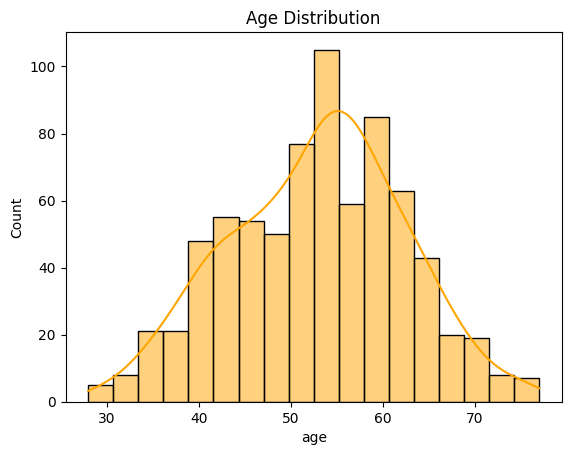

In [66]:
#histogram to see the distribution of age
sns.histplot(heart_df['age'], kde=True, color ="orange")
plt.title('Age Distribution')

#### SEX

In [67]:
#value counts of gender
heart_df['sex'].value_counts()

sex
Male      565
Female    183
Name: count, dtype: int64

In [68]:
#Male & female percenatge in the dataset
male_count = 726
female_count = 194
total_count = male_count + female_count

# calculate percentages
male_percentage = (male_count / total_count) * 100
female_percentage = (female_count / total_count) * 100

# display the results
print(f"Male percentage in the data: {male_percentage:.2f}%")
print(f"Female Percentage in the data: {female_percentage:.2f}%")

# difference
difference_percentage = ((male_count - female_count) / female_count) * 100
print(f"Males are {difference_percentage:.2f}% more than females in the data.")

Male percentage in the data: 78.91%
Female Percentage in the data: 21.09%
Males are 274.23% more than females in the data.


In [69]:
#histogram to see the distribution of gender on age using plotly
fig = px.histogram(heart_df, x='age', color='sex')
fig.show()

#### CP(CHEST PAINS)

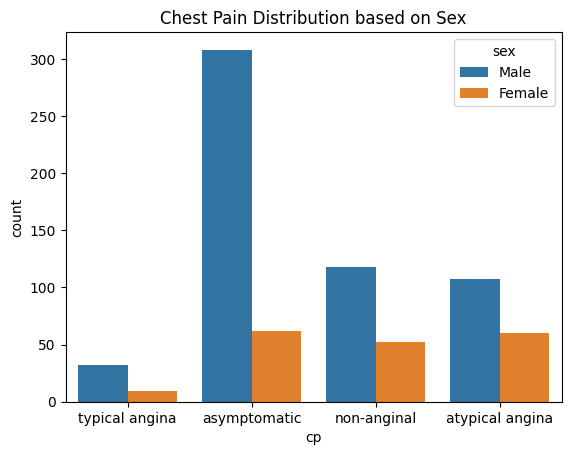

In [70]:
#plot the cp column using sns
sns.countplot(data=heart_df, x='cp', hue='sex')
plt.title('Chest Pain Distribution based on Sex')
plt.show()

In [71]:
#plot the cp based on age column using plotly
fig = px.histogram(heart_df, x='age', color='cp', nbins=50)
fig.show()

#### trestbps - RESTING BP

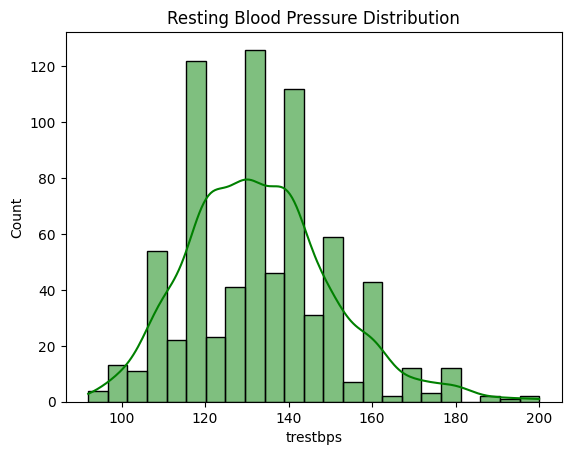

In [72]:
#histogram of trestbps column
sns.histplot(heart_df['trestbps'], kde=True, color='green')
plt.title('Resting Blood Pressure Distribution')
plt.show()

In [73]:
heart_df['trestbps'].value_counts().nlargest(5)

trestbps
120.0    110
130.0    101
140.0     90
150.0     49
110.0     47
Name: count, dtype: int64

#### Majority of the Patients have Resting Blood pressure ranges from 110-150 mm Hg

In [74]:
#Plot the distribution of resting Blood pressure (trestbps) based on gender
fig = px.histogram(heart_df, x='trestbps', color='sex', title='Resting Blood pressure (trestbps) based on gender')
fig.show()

#### CHOLESTROL

#### normal cholestrol level is less than 200mg/dL

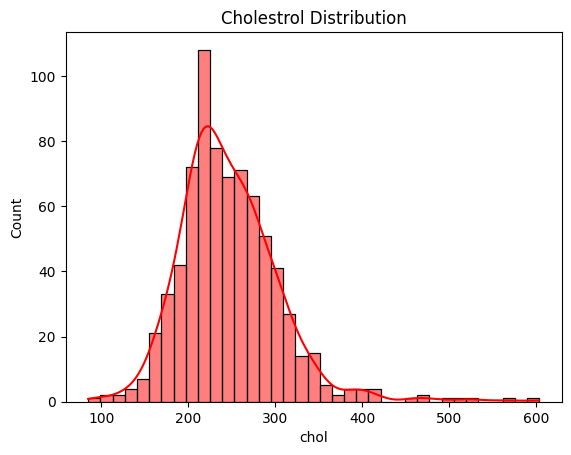

In [75]:
#plot the chol column
sns.histplot(heart_df['chol'], kde=True, color='red')
plt.title('Cholestrol Distribution')
plt.show()

In [76]:
heart_df['chol'].value_counts().nlargest(5)

chol
254.0    10
220.0    10
216.0     9
230.0     9
219.0     9
Name: count, dtype: int64

#### The majority of the patients have cholesterol levels between 200-300 mg/dl. Which is slightly higher than the normal range.

In [77]:
#Age Column binning
heart_df['age_bins'] = pd.cut(heart_df['age'], bins=[0, 30, 40, 50, 60, 70, 80], labels=['0-30', '31-40', '41-50', '51-60', '61-70', '71-80'])

In [78]:
heart_df['age_bins'].value_counts()

age_bins
51-60    305
41-50    202
61-70    140
31-40     76
71-80     20
0-30       5
Name: count, dtype: int64

<Axes: xlabel='age_bins', ylabel='chol'>

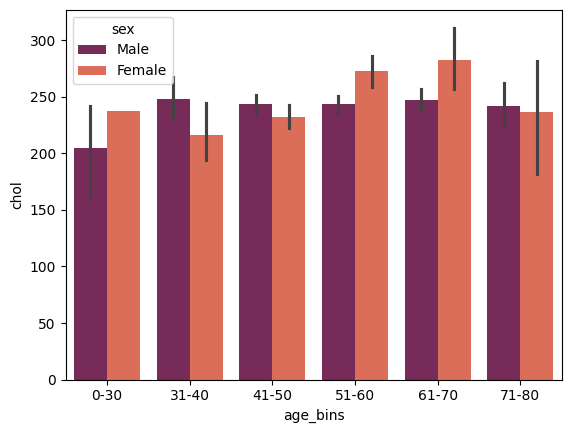

In [79]:
sns.barplot(data=heart_df, x='age_bins',y='chol', hue='sex', palette='rocket')

#### The cholesterol level is highest among the age group of 61-70 years

#### FBS - FASTING BLOOD SUGAR

<Axes: xlabel='sex', ylabel='fbs'>

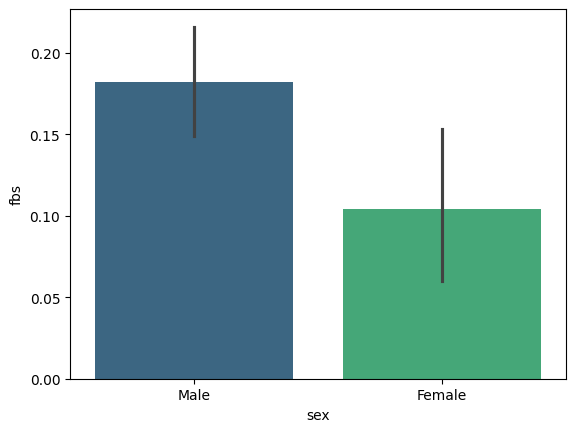

In [80]:
sns.barplot(data=heart_df, x='sex', y='fbs', palette='viridis')

In [81]:
# Rest ECG COUNTS
heart_df['restecg'].value_counts()

restecg
normal              446
lv hypertrophy      176
st-t abnormality    126
Name: count, dtype: int64

Normal:A healthy ECG reading with no signs of heart problems.

LV Hypertrophy: Thickening of the heart's left side, which can happen when the heart works too hard.

ST-T Abnormality: Unusual patterns in part of the ECG that may point to heart issues like reduced blood flow or heart attack.

#### REST ECG

In [82]:
fig = px.histogram(heart_df, x='age_bins', color='restecg', barmode='group', title='Resting ECG Results Based on Age')
fig.show()

#### THAL - Helps diagnose coronary artery disease and guides treatment decisions based on blood flow patterns.

In [83]:
heart_df['thal'].value_counts()

thal
reversable defect    375
normal               328
fixed defect          45
Name: count, dtype: int64

- Reversible Defect (353 cases): Indicates temporary reduced blood flow during stress, suggesting ischemia.
- Normal (325 cases): Shows normal blood flow, indicating no significant heart disease.
- Fixed Defect (62 cases): Indicates permanent reduced blood flow, suggesting previous heart damage.

<Axes: xlabel='age_bins', ylabel='count'>

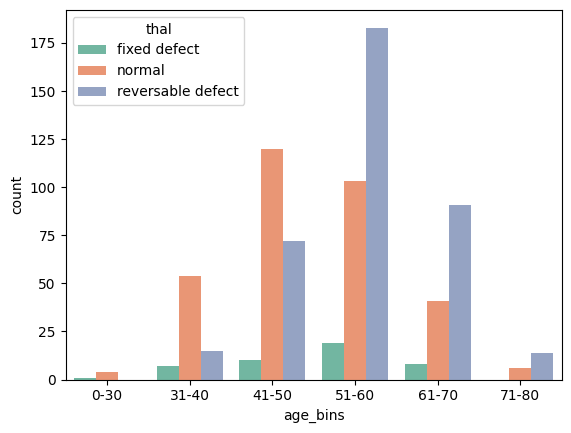

In [84]:
sns.countplot(data=heart_df, x='age_bins', hue='thal', palette='Set2')

<Axes: xlabel='sex', ylabel='count'>

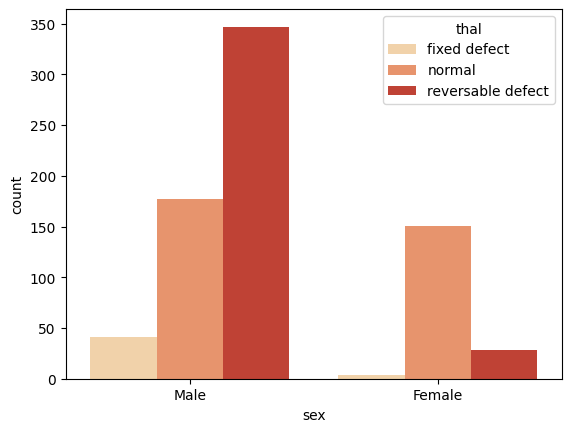

In [85]:
sns.countplot(data=heart_df, x='sex', hue='thal', palette='OrRd')

- Very few cases (1 female, 4 males) in 0-30 age group, indicating low heart disease risk.
- Significant increase in 41-50 age group, especially in males (144 cases), indicating higher risk.
- Highest count in 51-60 age group (233 males), suggesting urgent monitoring.
- Females consistently show lower counts across all age bins.
- Notable cases in 61-70 age group (32 females, 106 males), highlighting increased risk.

#### NUM - Heart disease

In [86]:
heart_df['num'].value_counts()

num
0    391
1    203
3     69
2     63
4     22
Name: count, dtype: int64

- 0 = no heart disease
- 1 = mild heart disease
- 2 = moderate heart disease
- 3 = severe heart disease
- 4 = critical heart disease

<Axes: xlabel='num', ylabel='count'>

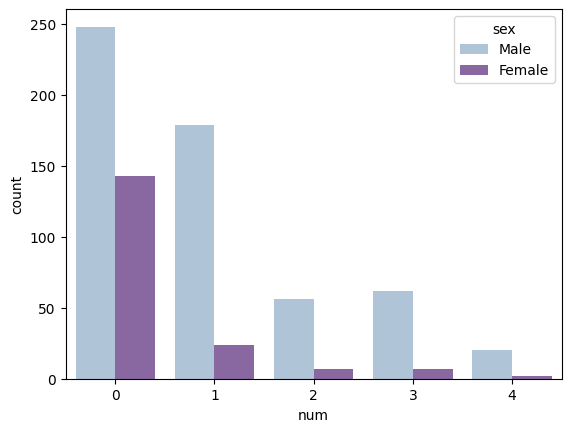

In [87]:
#plot num column on age_bins
sns.countplot(data=heart_df, x='num', hue='sex', palette='BuPu')

<Axes: xlabel='num', ylabel='count'>

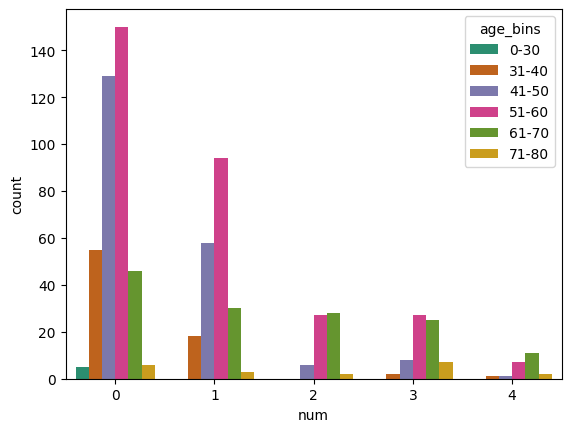

In [88]:
sns.countplot(data=heart_df, x='num', hue='age_bins', palette='Dark2')

- Minimal heart disease predictions in the 0-30 age group.
- Significant cases (especially num values 1 and 2) in the 41-50 age group.
- Severe predictions rise in 51-60 and 61-70 age groups for males.
- Females show fewer predicted heart disease cases overall.

## MACHINE LEARNING MODEL

In [89]:
# Apply Label Encoding to all object columns
label_encoders = {}
for column in heart_df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    heart_df[column] = le.fit_transform(heart_df[column].astype(str))
    label_encoders[column] = le

# Display the first few rows of the transformed dataset
heart_df.head(10)

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num,age_bins
0,1,63,1,0,3,145.0,233.0,1,0,150.0,0,2.3,0,0.0,0,0,61-70
1,2,67,1,0,0,160.0,286.0,0,0,108.0,1,1.5,1,3.0,1,2,61-70
2,3,67,1,0,0,120.0,229.0,0,0,129.0,1,2.6,1,2.0,2,1,61-70
3,4,37,1,0,2,130.0,250.0,0,1,187.0,0,3.5,0,0.0,1,0,31-40
4,5,41,0,0,1,130.0,204.0,0,0,172.0,0,1.4,2,0.0,1,0,41-50
5,6,56,1,0,1,120.0,236.0,0,1,178.0,0,0.8,2,0.0,1,0,51-60
6,7,62,0,0,0,140.0,268.0,0,0,160.0,0,3.6,0,2.0,1,3,61-70
7,8,57,0,0,0,120.0,354.0,0,1,163.0,1,0.6,2,0.0,1,0,51-60
8,9,63,1,0,0,130.0,254.0,0,0,147.0,0,1.4,1,1.0,2,2,61-70
9,10,53,1,0,0,140.0,203.0,1,0,155.0,1,3.1,0,0.0,2,1,51-60


In [90]:
heart_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 748 entries, 0 to 919
Data columns (total 17 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   id        748 non-null    int64   
 1   age       748 non-null    int64   
 2   sex       748 non-null    int32   
 3   dataset   748 non-null    int32   
 4   cp        748 non-null    int32   
 5   trestbps  748 non-null    float64 
 6   chol      748 non-null    float64 
 7   fbs       748 non-null    int32   
 8   restecg   748 non-null    int32   
 9   thalch    748 non-null    float64 
 10  exang     748 non-null    int32   
 11  oldpeak   748 non-null    float64 
 12  slope     748 non-null    int32   
 13  ca        748 non-null    float64 
 14  thal      748 non-null    int32   
 15  num       748 non-null    int64   
 16  age_bins  748 non-null    category
dtypes: category(1), float64(5), int32(8), int64(3)
memory usage: 76.9 KB


### Feature Selection (Statistically Significant)

In [91]:
# Check the unique values in the 'num' column
print(heart_df['num'].unique())

# Map 'num' to binary (e.g., 0: no disease, 1: disease present)
heart_df['num'] = heart_df['num'].apply(lambda x: 1 if x > 0 else 0)

# Verify the changes
print(heart_df['num'].unique())


logistic_model = logit("num ~ age + sex + dataset + cp + trestbps + chol + fbs + restecg + thalch + exang + oldpeak + slope + ca + thal", 
                       data=heart_df).fit()
print(logistic_model.summary())

[0 2 1 3 4]
[0 1]
Optimization terminated successfully.
         Current function value: 0.368533
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                    num   No. Observations:                  748
Model:                          Logit   Df Residuals:                      733
Method:                           MLE   Df Model:                           14
Date:                Fri, 15 Nov 2024   Pseudo R-squ.:                  0.4675
Time:                        17:24:25   Log-Likelihood:                -275.66
converged:                       True   LL-Null:                       -517.70
Covariance Type:            nonrobust   LLR p-value:                 2.192e-94
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.9074      1.464     -1.985      0.047      -5.777      -0.037
age        

#### From the above Logistic Regression model, we can see that only Sex, cp, chol, exang, oldPeak, slope and ca are statistically significant with p-value 0.05

### New logistic regression Model with above significant features

In [92]:
logistic_model = logit("num ~ sex + cp + chol + exang + oldpeak + slope + ca", data=heart_df).fit()
print(logistic_model.summary())


X_logistic = heart_df[['sex', 'cp', 'chol', 'exang', 'oldpeak', 'slope', 'ca']]
y_logistic = heart_df["num"]


predictions = logistic_model.predict(X_logistic) > 0.5 
cf_matrix = confusion_matrix(y_logistic, predictions)
accuracy = accuracy_score(y_logistic, predictions)

print(cf_matrix)
print("Accuracy of the new Model: ",accuracy)

Optimization terminated successfully.
         Current function value: 0.375408
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                    num   No. Observations:                  748
Model:                          Logit   Df Residuals:                      740
Method:                           MLE   Df Model:                            7
Date:                Fri, 15 Nov 2024   Pseudo R-squ.:                  0.4576
Time:                        17:24:25   Log-Likelihood:                -280.81
converged:                       True   LL-Null:                       -517.70
Covariance Type:            nonrobust   LLR p-value:                 3.443e-98
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.5945      0.649     -2.455      0.014      -2.867      -0.322
sex            1.4173      0.

In [93]:
#split the data into X and Y
X = heart_df.drop(['num','id','age_bins'], axis=1)
y = heart_df['num']

print (X)
print (y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

     age  sex  dataset  cp  trestbps   chol  fbs  restecg  thalch  exang  \
0     63    1        0   3    145.00  233.0    1        0  150.00      0   
1     67    1        0   0    160.00  286.0    0        0  108.00      1   
2     67    1        0   0    120.00  229.0    0        0  129.00      1   
3     37    1        0   2    130.00  250.0    0        1  187.00      0   
4     41    0        0   1    130.00  204.0    0        0  172.00      0   
..   ...  ...      ...  ..       ...    ...  ...      ...     ...    ...   
915   54    0        2   0    127.00  333.0    1        2  154.00      0   
916   62    1        2   3    146.32  139.0    0        2  117.34      0   
917   55    1        2   0    122.00  223.0    1        2  100.00      0   
918   58    1        2   0    149.86  385.0    1        0  119.14      1   
919   62    1        2   1    120.00  254.0    0        0   93.00      1   

     oldpeak  slope   ca  thal  
0      2.300      0  0.0     0  
1      1.500      1  

In [95]:
from sklearn.preprocessing import StandardScaler

models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'XG Boost': XGBClassifier(random_state=42)
    
}

params = {
    'Random Forest': {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [ 10,20],
        'model__min_samples_split': [2, 5]
    },
    'Gradient Boosting': {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.1, 0.01],
        'model__max_depth': [3, 5]
    },
    
    'Logistic Regression': {
        'model__C': [1, 10],
        'model__solver': ['lbfgs', 'liblinear']
    },
    'K-Nearest Neighbors': {
        'model__n_neighbors': [3, 5],
        'model__weights': ['uniform', 'distance']
    },
    
    'XG Boost': {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.1, 0.01],
        'model__max_depth': [3, 5]
    }
}

# Initialize best model tracking
best_model = None
best_accuracy = 0.0

# Train and evaluate each model
for name, model in models.items():
    print(f"Training {name}...")

    # Create a pipeline with the model
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])

    # Get hyperparameters for the current model
    model_params = params.get(name, {})

    # Create GridSearchCV with the pipeline and parameters
    grid_search = GridSearchCV(pipeline, model_params, cv=5, n_jobs=-1, verbose=0)

    # Fit the pipeline
    grid_search.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = grid_search.predict(X_test)

    # Print evaluation metrics
    print(f"{name} - Best Parameters: {grid_search.best_params_}")
    print(f"{name} - Best Score: {grid_search.best_score_}")
    print(f"{name} - Test Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f"{name} - Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")
    print(f"{name} - Classification Report:\n{classification_report(y_test, y_pred)}")
    print('\n')
    
    if accuracy_score(y_test, y_pred) > best_accuracy:
        best_accuracy = accuracy_score(y_test, y_pred)
        best_model = grid_search.best_estimator_

# print the best model & accuracy
print(f"The Best model is {best_model.named_steps['model']} with an accuracy of {best_accuracy*100}%")


Training Random Forest...
Random Forest - Best Parameters: {'model__max_depth': 20, 'model__min_samples_split': 5, 'model__n_estimators': 100}
Random Forest - Best Score: 0.8484671302149177
Random Forest - Test Accuracy: 0.8235294117647058
Random Forest - Confusion Matrix:
[[83 18]
 [15 71]]
Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.82      0.83       101
           1       0.80      0.83      0.81        86

    accuracy                           0.82       187
   macro avg       0.82      0.82      0.82       187
weighted avg       0.82      0.82      0.82       187



Training Gradient Boosting...
Gradient Boosting - Best Parameters: {'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__n_estimators': 200}
Gradient Boosting - Best Score: 0.8378634639696585
Gradient Boosting - Test Accuracy: 0.8235294117647058
Gradient Boosting - Confusion Matrix:
[[83 18]
 [15 71]]
Gradient Boosting - Classifi

In [96]:
from sklearn.ensemble import StackingClassifier
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Defining the base models
base_estimators = [
    ('random_forest', RandomForestClassifier(
        random_state=42,
        n_estimators= 300,
        max_depth=10,
        min_samples_split=2
    )),
    ('logistic_regression', LogisticRegression(
        random_state=42, 
        solver='lbfgs',
        C=1
    ))
]


# Defining the final estimator (XGBoost)
final_estimator = XGBClassifier(
    random_state=42, 
    n_estimators=200, 
    learning_rate=0.1, 
    max_depth=5
)

# Creating the Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=base_estimators,
    final_estimator=final_estimator,
    cv=5,
    n_jobs=-1
)

# Fit the stacking classifier
print("Training Stacking Classifier...")
stacking_clf.fit(X_train, y_train)

# Evaluate the stacking classifier
y_pred_stack = stacking_clf.predict(X_test)

# Print evaluation metrics
print("Stacking Classifier - Test Accuracy:", accuracy_score(y_test, y_pred_stack))
print("Stacking Classifier - Confusion Matrix:\n", confusion_matrix(y_test, y_pred_stack))
print("Stacking Classifier - Classification Report:\n", classification_report(y_test, y_pred_stack))


Training Stacking Classifier...
Stacking Classifier - Test Accuracy: 0.8128342245989305
Stacking Classifier - Confusion Matrix:
 [[79 22]
 [13 73]]
Stacking Classifier - Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.78      0.82       101
           1       0.77      0.85      0.81        86

    accuracy                           0.81       187
   macro avg       0.81      0.82      0.81       187
weighted avg       0.82      0.81      0.81       187

